In [1]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point

## NSS Data Science Project 2 - Silver Sharks Geospatial API

### 4. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [2]:
burglary_reports = pd.read_csv("../data/burglary_reports.csv", 
                                engine='python')

In [3]:
burglary_reports['geometry'] = burglary_reports\
                                               .apply(lambda x: Point((x.longitude,
                                                                       x.latitude)),
                                                      axis=1)

burglary_reports.head()

,Unnamed: 0,incident_number,offense_description,latitude,longitude,zip_code,date_reported,geometry
0,0,20210249540,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05,POINT (-86.77 36.15)
1,1,20210248840,BURGLARY- AGGRAVATED,36.20,-86.63,NaN,2021-05-04,POINT (-86.63 36.2)
2,2,20210244919,BURGLARY- AGGRAVATED,36.14,-86.78,NaN,2021-05-02,POINT (-86.78 36.14)
3,3,20210244892,BURGLARY- AGGRAVATED,36.14,-86.78,NaN,2021-05-02,POINT (-86.78 36.14)
4,4,20210249540,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05,POINT (-86.77 36.15)


### Builds the base area map of Nashville census tracts, on top of which we can then plot burglary locations.

In [4]:
census_tract = gpd.read_file('../data/tl_2019_47_tract/tl_2019_47_tract.shp')
type(census_tract)

geopandas.geodataframe.GeoDataFrame

In [5]:
print(census_tract.crs)
display(census_tract.head())

epsg:4269


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56852, -86.53713 36.568..."
3,47,165,020902,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,+36.3724350,-086.4411274,"POLYGON ((-86.47106 36.38238, -86.47081 36.382..."
4,47,165,020800,47165020800,208,Census Tract 208,G5020,S,10235406,37743,+36.4005117,-086.4528100,"POLYGON ((-86.48786 36.37320, -86.48783 36.373..."


In [6]:
census_tract = census_tract[['COUNTYFP', 
                             'TRACTCE', 
                             'NAME', 
                             'geometry']]

census_tract['COUNTYFP'] = census_tract['COUNTYFP']\
                                                   .apply(pd.to_numeric)

census_tract = census_tract[census_tract['COUNTYFP'] == 37]

census_tract.head()

,COUNTYFP,TRACTCE,NAME,geometry
27,37,010106,101.06,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
36,37,010103,101.03,"POLYGON ((-86.91752 36.33976, -86.91747 36.339..."
37,37,010202,102.02,"POLYGON ((-86.82482 36.33225, -86.82480 36.332..."
38,37,010104,101.04,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
63,37,013300,133,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."


In [7]:
burglary_geo = gpd.GeoDataFrame(burglary_reports,
                                crs = census_tract.crs,
                                geometry = burglary_reports['geometry'])

In [8]:
print(burglary_geo.crs)
display(burglary_geo.head())

epsg:4269


,Unnamed: 0,incident_number,offense_description,latitude,longitude,zip_code,date_reported,geometry
0,0,20210249540,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05,POINT (-86.77000 36.15000)
1,1,20210248840,BURGLARY- AGGRAVATED,36.20,-86.63,NaN,2021-05-04,POINT (-86.63000 36.20000)
2,2,20210244919,BURGLARY- AGGRAVATED,36.14,-86.78,NaN,2021-05-02,POINT (-86.78000 36.14000)
3,3,20210244892,BURGLARY- AGGRAVATED,36.14,-86.78,NaN,2021-05-02,POINT (-86.78000 36.14000)
4,4,20210249540,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05,POINT (-86.77000 36.15000)


In [9]:
burglary_by_tract = gpd.sjoin(burglary_geo, 
                              census_tract, 
                              op = 'within')

In [10]:
# drops redundant index
burglary_by_tract = burglary_by_tract.drop(columns='index_right')

# renames tract column
burglary_by_tract = burglary_by_tract\
                                     .rename(columns={'TRACTCE':'tract'})

#burglary_by_tract = burglary_by_tract\
 #                                    .drop(columns='incident_number')

#burglary_by_tract = burglary_by_tract.drop_duplicates(keep='first')

print(burglary_by_tract.shape)
display(burglary_by_tract.head())

(1049, 10)


,Unnamed: 0,offense_description,latitude,longitude,zip_code,date_reported,geometry,COUNTYFP,tract,NAME
0,0,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05,POINT (-86.77000 36.15000),37,016000,160
4,4,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05,POINT (-86.77000 36.15000),37,016000,160
63,63,BURGLARY- AGGRAVATED,36.14,-86.76,NaN,2021-04-02,POINT (-86.76000 36.14000),37,016000,160
129,129,BURGLARY- AGGRAVATED,36.14,-86.76,NaN,2021-01-05,POINT (-86.76000 36.14000),37,016000,160
158,158,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-04-21,POINT (-86.77000 36.15000),37,016000,160


In [11]:
census_tract_names = burglary_by_tract['NAME']

census_tract_names = pd.DataFrame(census_tract_names)

polygon_nash = pd.merge(census_tract, 
                        census_tract_names, 
                        on = 'NAME')

polygon_nash.drop_duplicates(subset='NAME')

,COUNTYFP,TRACTCE,NAME,geometry
0,37,010106,101.06,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
9,37,010202,102.02,"POLYGON ((-86.82482 36.33225, -86.82480 36.332..."
10,37,010104,101.04,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
18,37,013300,133,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."
31,37,018102,181.02,"POLYGON ((-86.88737 36.11771, -86.88733 36.117..."
...,...,...,...,...
996,37,018904,189.04,"POLYGON ((-86.73805 36.06626, -86.73780 36.066..."
1006,37,018905,189.05,"POLYGON ((-86.74457 36.05547, -86.74447 36.055..."
1030,37,013601,136.01,"POLYGON ((-86.84383 36.16325, -86.84375 36.163..."
1035,37,018301,183.01,"POLYGON ((-87.03820 36.09382, -87.03819 36.093..."


### This gets burglaries-per-1000 information from Step 3 and re-adds leading zeroes that were dropped during CSV conversion.

In [16]:
tract_pop_income = pd.read_csv("../data/tract_pop_income.csv",
                               dtype = {'tract': 'object'})

tract_pop_income['tract'] = '0' + tract_pop_income['tract']

print(tract_pop_income.shape)
display(tract_pop_income.head(5))

(146, 7)


,Unnamed: 0,tract,population,median_income,burglary_count,burg_per_1000,log_population
0,0,010104,2955,64844,8,2.707276,7.991254
1,1,010105,4435,64688,3,0.676437,8.397283
2,2,010106,3397,63864,9,2.649397,8.130648
3,3,010201,4157,62829,4,0.962232,8.332549
4,4,010202,3962,78750,1,0.252398,8.284504


### This plots burglary locations on top of the Nashville census tract area map.

In [13]:
pop_inc_geo = pd.merge(burglary_by_tract, 
                       tract_pop_income,
                       on = 'tract')

In [17]:
pop_inc_geo = pop_inc_geo\
                         .drop(columns=['Unnamed: 0_x',
                                        'offense_description',
                                        'latitude',
                                        'longitude',
                                        'zip_code',
                                        'Unnamed: 0_y'])

In [23]:
pop_inc_geo = pop_inc_geo.drop_duplicates(keep='first')

In [24]:
pop_inc_geo.head(15)

,date_reported,geometry,COUNTYFP,tract,NAME,population,median_income,burglary_count,burg_per_1000,log_population
0,2021-05-05,POINT (-86.77000 36.15000),37,016000,160,945,37083,8,8.465608,6.851185
2,2021-04-02,POINT (-86.76000 36.14000),37,016000,160,945,37083,8,8.465608,6.851185
3,2021-01-05,POINT (-86.76000 36.14000),37,016000,160,945,37083,8,8.465608,6.851185
4,2021-04-21,POINT (-86.77000 36.15000),37,016000,160,945,37083,8,8.465608,6.851185
5,2021-01-08,POINT (-86.76000 36.14000),37,016000,160,945,37083,8,8.465608,6.851185
6,2021-05-25,POINT (-86.76000 36.14000),37,016000,160,945,37083,8,8.465608,6.851185
7,2021-05-23,POINT (-86.77000 36.15000),37,016000,160,945,37083,8,8.465608,6.851185
8,2021-05-04,POINT (-86.63000 36.20000),37,015402,154.02,4717,69740,8,1.695993,8.458928
9,2021-02-27,POINT (-86.64000 36.19000),37,015402,154.02,4717,69740,8,1.695993,8.458928
10,2021-04-29,POINT (-86.63000 36.20000),37,015402,154.02,4717,69740,8,1.695993,8.458928


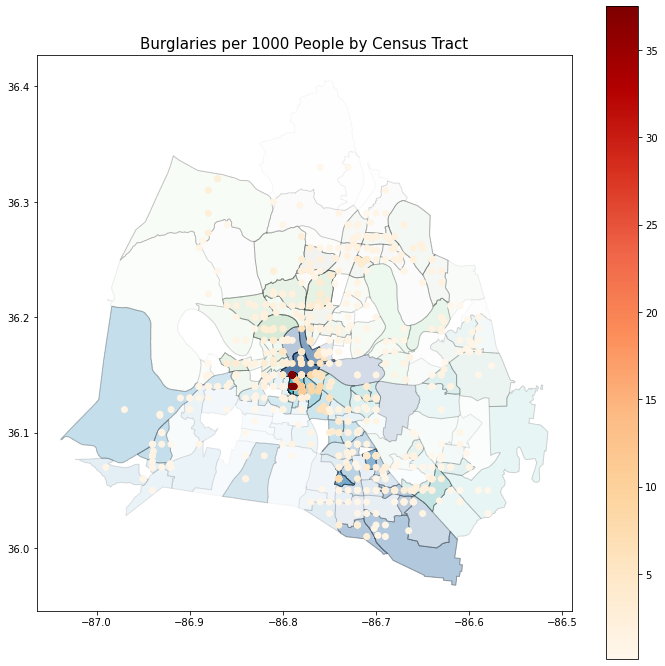

In [28]:
ax = polygon_nash.plot(column='TRACTCE', 
                       figsize = (12, 12), 
                       edgecolor='black',
                       alpha=0.03,
                       cmap='GnBu')
pop_inc_geo.plot(column = 'burg_per_1000',
                 cmap='OrRd',
                 legend=True,
                 ax=ax)
plt.title('Burglaries per 1000 People by Census Tract',
          fontsize=15)
plt.show();